In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## PASCAL VOC data setup

In [2]:
# BASE_PATH = '/content/drive/MyDrive/ai/detection/detection-tutorial/'
BASE_PATH = '/content/drive/MyDrive/ai/detection/'

In [3]:
!ls {BASE_PATH}

detection-tutorial     faster_rcnn_model_0.pth	VOCtrainval_11-May-2012.tar
detectron2_test.ipynb  setup.ipynb


In [4]:
file = BASE_PATH + 'VOCtrainval_11-May-2012.tar'

In [5]:
%%time
!cp {file} .

CPU times: user 350 ms, sys: 73.5 ms, total: 424 ms
Wall time: 1min 13s


In [6]:
%%time
!tar -xvf ./VOCtrainval_11-May-2012.tar > /dev/null

CPU times: user 196 ms, sys: 49.2 ms, total: 245 ms
Wall time: 50.6 s


In [7]:
!pwd

/content


In [8]:
!ls

drive  sample_data  VOCdevkit  VOCtrainval_11-May-2012.tar


## Imports

In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

In [11]:
os.chdir("drive/My Drive/ai/detection/detection-tutorial")
# os.chdir("/content/")

In [12]:
# import sys
# sys.path.append('./dataset/')
# sys.path.append('./')
# sys.path

In [3]:
from transforms import get_transform
from utils import format_time, seed_everything
from utils import generate_anchors, process_anchors, find_jaccard_overlap
from utils_plot import show_predictions, show_image_and_bb, show_anchors, show_image_from_dataset

from loss import BoxLoss
from train import run_loader, get_device

from faster_rcnn import faster_rcnn

In [4]:
# !mkdir ./pascal-voc

In [5]:
# from dataset.pascal_voc_utils import create_data_lists
# create_data_lists(
#     voc07_path=None,
#     voc12_path='/content/VOCdevkit/VOC2012/',
#     # voc12_path='../VOCdevkit/VOC2012/',
#     output_folder='./pascal-voc/'
# )

In [6]:
SEED = 2021
seed_everything(SEED)

## PennFudanDataset

In [ ]:
from dataset.penn_fudan_dataset import PennFudanDataset

In [ ]:
# dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))
dataset = PennFudanDataset('../PennFudanPed', None)

In [ ]:
image, target = dataset[0]

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
target

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

tensor([159., 181., 301., 430.])
tensor([419., 170., 534., 485.])


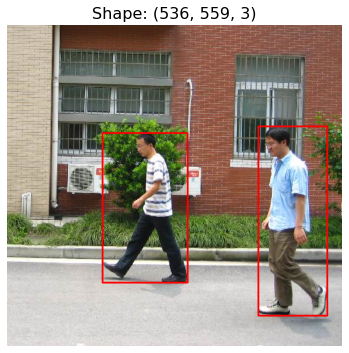

In [ ]:
# show_image(dataset, 0)
show_image_and_bb(image, target)

In [ ]:
anchors = generate_anchors()

In [ ]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [ ]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [ ]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [ ]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [ ]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [ ]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

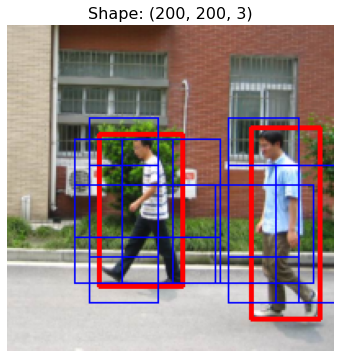

In [ ]:
show_anchors(image, target['boxes'], top_n_anchors)

## PASCAL VOC dataset

In [7]:
from dataset.pascal_voc_dataset import PascalVOCDataset
from utils import generate_anchors

In [8]:
# dataset = PascalVOCDataset('/content/pascal-voc/', 'TRAIN', get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/', 'TRAIN', get_transform(train=True))

In [9]:
anchors = generate_anchors()
anchors.shape

torch.Size([2577, 4])

In [24]:
25*25, 25*25 + 13*13, 25*25 + 13*13 + 7*7, 25*25 + 13*13 + 7*7 + 4*4


(625, 794, 843, 859)

GT:
tensor([107.6000,   0.0000, 150.8000, 107.0336])
tensor([22.4000,  0.0000, 65.2000, 91.1315])
Predictions:
tensor([ 80.0000, 144.0000, 120.0000, 184.0000])
tensor([ 71.7157, 149.8579, 128.2843, 178.1421])
tensor([ 85.8579, 135.7157, 114.1421, 192.2843])
Shape: (200, 200, 3)


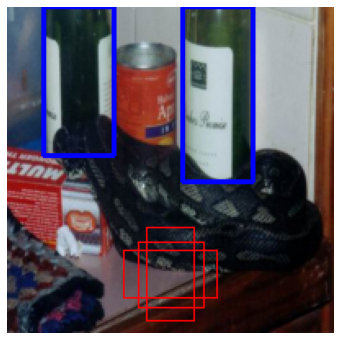

In [11]:
index = 5
image, target = dataset[index]

gt_boxes = target['boxes']

N = 3
start = 320
anchors_to_show = anchors[start*N:(start+1)*N]

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, anchors_to_show, verbose=True)

In [57]:
from torchvision.ops import boxes as box_ops
box_similarity = box_ops.box_iou

In [64]:
index = 4
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(clip=True)

In [65]:
gt_boxes

tensor([[0.4320, 0.4267, 0.5860, 0.5867],
        [0.9280, 0.4427, 0.9980, 0.5787]])

In [77]:
threshold = 0.5
# jaccard = find_jaccard_overlap(anchors, gt_boxes)
jaccard = box_similarity(anchors, gt_boxes)
print(jaccard.shape)

torch.Size([2577, 2])


In [113]:
def get_positive_anchors(anchors, gt_boxes, threshold=0.3):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)

    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)

    max_iou_for_anchors, gt_boxes_id_for_anchors = jaccard.max(1) # (N1), (N1)

    # fix cases when gt box has no anchor above threshold
    n_objects = gt_boxes.shape[0]
    _, anchor_id_for_object = jaccard.max(0) # (N2), (N2)
    gt_boxes_id_for_anchors[anchor_id_for_object] = torch.LongTensor(range(n_objects))
    max_iou_for_anchors[anchor_id_for_object] = 1

    positive_anchors_mask = (max_iou_for_anchors > threshold) # (N1)
    gt_boxes_id_for_positive_anchors = gt_boxes_id_for_anchors[positive_anchors_mask] # (n_pos_anchors)

    gt_boxes_for_positive_anchors = gt_boxes[gt_boxes_id_for_positive_anchors]  # (n_pos_anchors, 4)
    positive_anchors = anchors[positive_anchors_mask] # (n_pos_anchors, 4)
    positive_iou = max_iou_for_anchors[positive_anchors_mask] # (n_pos_anchors, 1)
    
    return positive_anchors, positive_iou, gt_boxes_for_positive_anchors

Positive anchors number: 10/2577


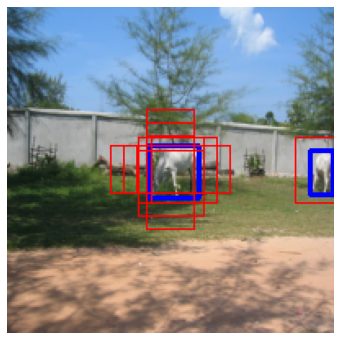

In [146]:
index = 4
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(clip=True)

top_n_anchors, top_n_iou, pos_gt_boxes = get_positive_anchors(anchors, gt_boxes, threshold=0.5)
# top_n_anchors, top_n_iou = get_top_n_anchors(anchors, gt_boxes, top_n=10)

print(f'Positive anchors number: {top_n_anchors.shape[0]}/{anchors.shape[0]}')
# print(top_n_iou)

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, top_n_anchors, verbose=False)

In [ ]:
# index = 5
# show_image_from_dataset(dataset, index, top_n_anchors=10, verbose=True)

## Model single path

In [118]:
device = get_device()

No GPU available, using the CPU instead.


In [119]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [120]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [121]:
images, targets = next(iter(data_loader))
images = torch.stack(images, dim=0).to(device)
images.shape

torch.Size([8, 3, 200, 200])

In [122]:
# targets

In [123]:
net = faster_rcnn(device).to(device)

In [124]:
offsets, labels = net(images)
offsets.shape, labels.shape

(torch.Size([8, 2577, 4]), torch.Size([8, 2577, 1]))

In [138]:
criterion = BoxLoss(device, anchor_threshold=0.3)

In [139]:
loss = criterion(labels, offsets, targets)

In [140]:
loss

(tensor(2.2488, grad_fn=<AddBackward0>),
 tensor(1.5441, grad_fn=<SmoothL1LossBackward>),
 tensor(0.7047, grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [141]:
-np.log(1/2)

0.6931471805599453

In [142]:
gt_labels, gt_offsets = criterion.process_target_batch(targets)

In [143]:
gt_labels.shape

torch.Size([8, 2577])

In [144]:
torch.unique(gt_labels, return_counts=True)

(tensor([0, 1], dtype=torch.int32), tensor([19520,  1096]))

In [145]:
torch.unique(torch.tensor([1,1,0,2]), return_counts=True)

(tensor([0, 1, 2]), tensor([1, 2, 1]))

## Train Model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
len(train_loader)

1443

In [ ]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}

model = faster_rcnn()

run_loader(model, train_loader, None, **params)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[train] index:  0, loss(box/cls) = 2.51103(1.77640/0.73463) time: 0:00:00


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index: 100, loss(box/cls) = 2.08980(1.67377/0.41603) time: 0:00:07
[train] index: 200, loss(box/cls) = 1.53724(1.12103/0.41621) time: 0:00:14
[train] index: 300, loss(box/cls) = 1.54284(1.17414/0.36871) time: 0:00:20
[train] index: 400, loss(box/cls) = 1.33409(0.94387/0.39022) time: 0:00:27
[train] index: 500, loss(box/cls) = 1.23265(0.95894/0.27371) time: 0:00:34
[train] index: 600, loss(box/cls) = 1.47188(1.15760/0.31429) time: 0:00:41
[train] index: 700, loss(box/cls) = 1.38084(1.11081/0.27003) time: 0:00:48
[train] index: 800, loss(box/cls) = 1.13748(0.78485/0.35264) time: 0:00:54
[train] index: 900, loss(box/cls) = 1.44728(1.20427/0.24301) time: 0:01:01
[train] index: 1000, loss(box/cls) = 1.23932(0.86597/0.37335) time: 0:01:08
[train] index: 1100, loss(box/cls) = 0.96726(0.75159/0.21567) time: 0:01:14
[train] index: 1200, loss(box/cls) = 1.32545(1.02724/0.29821) time: 0:01:21
[train] index: 1300, loss(box/cls) = 1.23931(0.93166/0.30765) time: 0:01:28
[train] index: 1400, 

{}

## Run

In [67]:
from train import main, run

In [68]:
from utils_plot import show_loss_history, show_loss_epochs_all, show_scores

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [70]:
# train_info = main(debug=True)

In [76]:
params = {
    'anchor_threshold' : 0.3,
    'learning_rate'    : 0.001,
    'weight_decay'     : 0,
    'batch_size'       : 8,
    'num_epoch'        : 15,
    'verbose'          : True,
    'debug'            : False
}

seed_everything(SEED)
train_info, valid_loader, model = run(**params)

data size, all: 11540, train: 10386
data loader size, train: 1299, valid: 145, batch_size 8
anchor_threshold = 0.3
learning_rate = 0.001
weight_decay = 0
num_epoch = 15

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
training started...
[train] epoch:  1, loss(box/cls) = 1.16177(1.01167/0.15010), time: 0:02:01
[valid] epoch:  1, loss(box/cls) = 1.13085(0.97921/0.15164), mAP = 0.20422,  time: 0:02:18
[train] epoch:  2, loss(box/cls) = 1.01812(0.88888/0.12925), time: 0:02:02
[valid] epoch:  2, loss(box/cls) = 1.08206(0.93683/0.14523), mAP = 0.24050,  time: 0:02:22
[train] epoch:  3, loss(box/cls) = 0.94680(0.82527/0.12153), time: 0:02:01
[valid] epoch:  3, loss(box/cls) = 1.04744(0.90965/0.13779), mAP = 0.24899,  time: 0:02:20
[train] epoch:  4, loss(box/cls) = 0.88974(0.77396/0.11579), time: 0:02:01
[valid] epoch:  4, loss(box/cls) = 1.00671(0.87319/0.13352), mAP = 0.26784,  time: 0:02:19
[train] epoch:  5, loss(box/cls) = 0.84295(0.73185/0.11110), time: 0:02:01
[valid] epo

In [72]:
epochs = 120000 // (len(dataset) // 32)
epochs

In [109]:
# train_info['train_cls_loss_history']

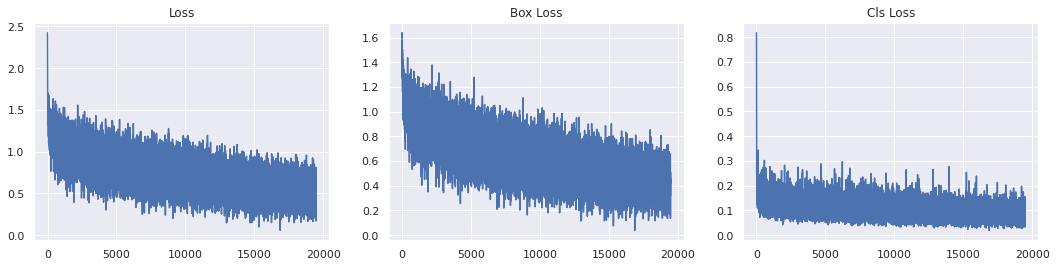

In [77]:
show_loss_history(train_info)

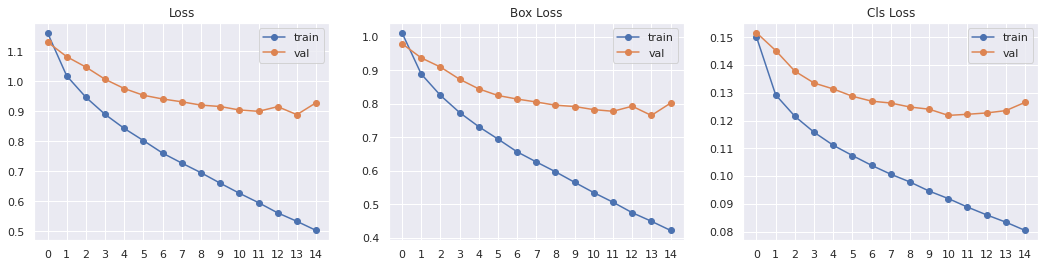

In [78]:
show_loss_epochs_all(train_info)

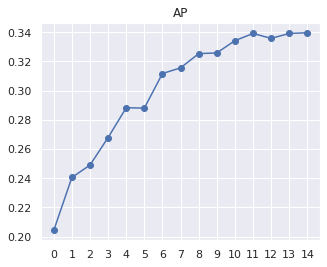

In [79]:
show_scores(train_info)

In [98]:
model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
torch.save(model.state_dict(), model_path)

## Show predictions

In [80]:
from utils_plot import show_predictions

In [81]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [82]:
len(valid_loader)

145

In [83]:
images, targets = next(iter(valid_loader))

In [84]:
images = torch.stack(images, dim=0).to(device)

In [85]:
# model = faster_rcnn(device)

# model_path = '../pth/faster_rcnn_model_0.pth'
# model.load_state_dict(torch.load(model_path, map_location='cpu'))

# model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
# model.load_state_dict(torch.load(model_path))

In [86]:
model.eval()
print('')

In [87]:
offsets, labels = model(images)

In [88]:
pred_boxes, pred_conf = model.detect(offsets, labels, prob_threshold=0.5, max_overlap=0.5)

GT:
tensor([  0.0000,  91.8919, 199.2000, 187.9880])
Predictions:
tensor([ 45.7957, 110.1085, 151.2097, 187.0080], grad_fn=<UnbindBackward>)
tensor([ 94.1819, 114.2422, 179.3792, 186.3195], grad_fn=<UnbindBackward>)
Shape: (200, 200, 3)


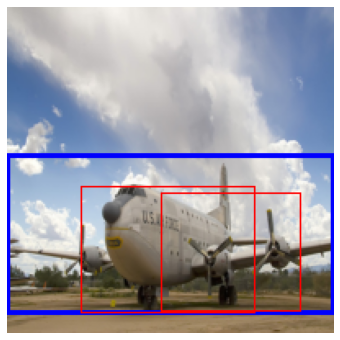

In [97]:
plt.figure(figsize=(6,6))
image_index = 0
gt_boxes = targets[image_index]['boxes']
final_boxes = pred_boxes[image_index].cpu()
show_predictions(images[image_index], gt_boxes, final_boxes, verbose=True)

## Evaluation

In [ ]:
from utils import calculate_mAP

In [ ]:
det_boxes = pred_boxes
det_scores = pred_conf
true_boxes = [t['boxes'] for t in targets]
true_labels = [t['labels'] for t in targets]

NameError: ignored

In [ ]:
calculate_mAP(pred_boxes, pred_conf, true_boxes, true_labels, device)

tensor(0.3829, device='cuda:0')

In [ ]:
from train import validate

In [ ]:
criterion = BoxLoss(device)

In [ ]:
loss_meters, mAP = validate(model, device, criterion, valid_loader)

[valid] index:  0, loss(box/cls) = 0.55522(0.36432/0.19090) time: 0:00:00
[valid] index: 100, loss(box/cls) = 0.52522(0.37740/0.14782) time: 0:00:08
[valid] calculate_mAP... time: 0:00:12
[valid] mAP = 0.24425,  time: 0:00:13


In [ ]:
mAP

tensor(0.2871, device='cuda:0')

## ipywidgets

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
# dataset = PascalVOCDataset('./pascal-voc/', transforms=get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/')

get_transform_to_show


In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Image:',
    disabled=False
)

def handle_change(x):
    print(x)
    show_image_from_dataset(dataset, x, top_n_anchors=0)

In [ ]:
# do it only once

# import json
# # with open('./pascal-voc/label_map.json'), 'r') as j:
# data_folder = './pascal-voc'
# with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
#     labels = json.load(j)

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Image:', max=11540), Output()), _dom_classes=('widg…

<function __main__.handle_change(x)>

## Trainimg